In [102]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [103]:
''' 
Functie care incarca imaginile din subfolderele "normal" si "sepia".
Returneaza X - imagini scalate si redimensionate, si y - etichete binare (0/1).
'''
def incarca_imagini_din_directoare(cale_baza, dimensiune=(64, 64)):
    X, y = [], []
    for label, subfolder in enumerate(['normal', 'sepia']):
        cale_completa = os.path.join(cale_baza, subfolder)
        for fisier in os.listdir(cale_completa):
            img_path = os.path.join(cale_completa, fisier)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, dimensiune)
                img = img.astype('float32') / 255.0
                X.append(img)
                y.append(label)
    return np.array(X), np.array(y)

In [104]:
''' 
Afiseaza distributia claselor (normal vs sepia) in histograma.
Ajuta la verificarea echilibrului datasetului.
'''
def afiseaza_distributie_etichete(y):
    plt.bar(['normal', 'sepia'], [np.sum(y == 0), np.sum(y == 1)], color=['#f8bbd0', '#ce93d8'])  
    plt.title("Distributia etichetelor", fontsize=14, color='#880e4f') 
    plt.ylabel("Numar imagini", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

In [105]:
''' 
Functie utilitara pentru evaluarea unui model de clasificare:
- afiseaza classification report
- afiseaza confusion matrix
'''
def evalueaza_model(y_test, y_pred, titlu="Evaluare model"):
    print(classification_report(y_test, y_pred, target_names=['normal', 'sepia'], zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'sepia'])
    disp.plot(cmap=plt.cm.PuRd) 
    plt.title(titlu)
    plt.show()

In [106]:
''' 
Antreneaza un model ANN folosind MLPClassifier (sklearn).
Foloseste imagini flattenate si afiseaza performanta modelului.
'''
def antreneaza_ann_pe_imagini(X, y):
    X_flat = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
    model = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', max_iter=500, solver='adam', verbose=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("\n[Rezultate ANN - sklearn MLPClassifier (tool)]")
    evalueaza_model(y_test, y_pred, "Confusion Matrix - ANN Tool")

In [112]:
''' 
Testeaza influenta hiperparametrilor asupra performantei ANN-ului.
Se modifica numarul de neuroni si rata de invatare.
'''
def testeaza_hiperparametri_ann(X, y):
    X_flat = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)
    for neuroni in [64, 128]:
        for lr in [0.001, 0.01]:
            model = MLPClassifier(hidden_layer_sizes=(neuroni,), activation='relu', max_iter=500,
                                  solver='adam', learning_rate_init=lr, random_state=42)
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            print(f"[ANN hiperparametri] Neuroni: {neuroni}, Learning rate: {lr} -> Acuratete: {acc:.2f}")

In [113]:
''' 
Antreneaza un CNN simplu (convolutional neural network) folosind Keras.
Foloseste imagini direct (fara flatten), convolutii si maxpooling.
'''
def antreneaza_cnn_propriu(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = Sequential([
        tf.keras.Input(shape=(64, 64, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print("\n[Rezultate CNN Cod Propriu]")
    evalueaza_model(y_test, y_pred, "Confusion Matrix - CNN")

In [117]:
def antreneaza_ann_cod_propriu(X, y, epoci=1000, rata=0.01, dim_hidden=128):
    """
    Implementeaza un model ANN simplu in NumPy.
    Are un singur strat ascuns si foloseste tanh + sigmoid cu binary cross-entropy.
    """
    X_flat = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

    y_train = y_train.reshape(-1, 1).astype(float)
    y_test = y_test.reshape(-1, 1).astype(float)

    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_deriv(a):
        return a * (1 - a)

    def tanh(z):
        return np.tanh(z)

    def tanh_deriv(a):
        return 1 - a ** 2

    np.random.seed(42)
    m, n = X_train.shape
    W1 = np.random.randn(n, dim_hidden) * 0.01
    b1 = np.zeros((1, dim_hidden))
    W2 = np.random.randn(dim_hidden, 1) * 0.01
    b2 = np.zeros((1, 1))

    for _ in range(epoci):
        # Forward
        Z1 = X_train @ W1 + b1
        A1 = tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = sigmoid(Z2)
        E = A2 - y_train
        
        dZ2 = E * sigmoid_deriv(A2)
        dW2 = A1.T @ dZ2 / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dZ1 = dZ2 @ W2.T * tanh_deriv(A1)
        dW1 = X_train.T @ dZ1 / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        W2 -= rata * dW2
        b2 -= rata * db2
        W1 -= rata * dW1
        b1 -= rata * db1

    A1_test = tanh(X_test @ W1 + b1)
    A2_test = sigmoid(A1_test @ W2 + b2)
    predictii = (A2_test > 0.5).astype(int)

    print("\n[Rezultate ANN Cod Propriu (NumPy) - Imbunatatit]")
    print(classification_report(y_test, predictii, target_names=['normal', 'sepia'], zero_division=0))


In [118]:
''' 
Ruleaza toate componentele temei:
- Incarcare date
- Verificare distributie
- Clasificare cu MLPClassifier (tool)
- Testare hiperparametri
- Clasificare cu ANN cod propriu
- Clasificare cu CNN (cod propriu)
'''
def executa_tot_pipeline():
    X, y = incarca_imagini_din_directoare("images")
    afiseaza_distributie_etichete(y)
    print("--- Tool: MLPClassifier ANN ---")
    antreneaza_ann_pe_imagini(X, y)
    print("\n--- Hiperparametri ANN ---")
    testeaza_hiperparametri_ann(X, y)
    print("\n--- ANN Cod Propriu (NumPy) ---")
    antreneaza_ann_cod_propriu(X, y)
    print("\n--- CNN Cod Propriu ---")
    antreneaza_cnn_propriu(X, y)

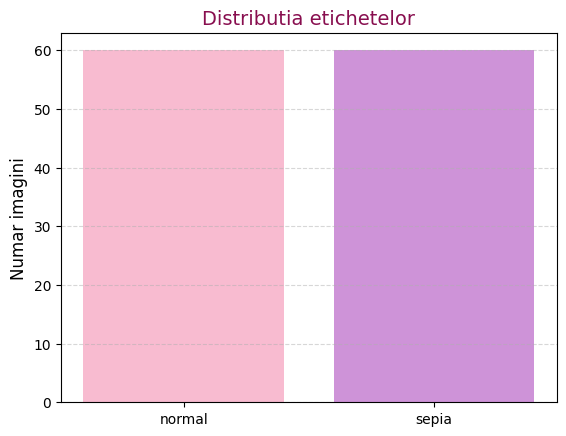

--- Tool: MLPClassifier ANN ---


In [ ]:
executa_tot_pipeline()